In [1]:
from datetime import timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pykalman import KalmanFilter


EPSILON = 1e-10
RETURN_SCALE = 100

# if __name__ == "__main__":

start_time = '1577836800'
end_time = '1578441600'

# df_ = get_prices(
#     'btc', 'usdt',
#     datetime(2020, 1, 1),
#     duration=timedelta(days=7),
#     proxy_port='13070',
#     verbose=2)

df_ = pd.read_csv('data/BTCUSDT[' + start_time + '000_' + end_time + '000].csv')
df_.drop(['Unnamed: 0'], inplace=True, axis=1)
df_['Time'] = pd.to_datetime(df_['Time'])
df_.set_index('Time', inplace=True, drop=True)

times_index = pd.date_range(start=pd.to_datetime(start_time, unit='s'),
                            end=pd.to_datetime(end_time, unit='s'),
                            periods=(int(end_time) - int(start_time) + 1) / 60 + 1)

df = pd.DataFrame(None, columns=df_.columns, index=times_index[:-1])

selected_indices = list(set(df_.index).intersection(set(times_index)))
df.loc[selected_indices, df_.columns] = df_.loc[selected_indices].copy()
df

,Market,Open,High,Low,Close,Volume,Value,No. Trades,Taker Buy Volume,Taker Buy Value
2020-01-01 00:00:00,BTCUSDT,7195.24,7196.25,7183.14,7186.68,51.642812,371233.518355,493,19.59823,140888.414283
2020-01-01 00:01:00,BTCUSDT,7187.67,7188.06,7182.2,7184.03,7.248148,52080.127788,135,2.031772,14599.211924
2020-01-01 00:02:00,BTCUSDT,7184.41,7184.71,7180.26,7182.43,11.681677,83903.741635,202,5.479244,39357.081776
2020-01-01 00:03:00,BTCUSDT,7183.83,7188.94,7182.49,7185.94,10.025391,72033.226649,136,3.294966,23680.571924
2020-01-01 00:04:00,BTCUSDT,7185.54,7185.54,7178.64,7179.78,14.911105,107066.521825,161,2.369033,17012.015138
...,...,...,...,...,...,...,...,...,...,...
2020-01-07 23:55:00,BTCUSDT,8163.09,8180.78,8162.58,8174.52,56.340474,460369.470177,664,34.532792,282162.676837
2020-01-07 23:56:00,BTCUSDT,8174.52,8176.52,8162.58,8168.48,46.824082,382487.910867,442,18.526946,151332.558308
2020-01-07 23:57:00,BTCUSDT,8167.76,8170.67,8157.5,8158.96,42.212437,344654.966852,403,19.19538,156750.172947
2020-01-07 23:58:00,BTCUSDT,8158.73,8162.0,8153.77,8161.5,103.923,847779.49378,538,56.297305,459258.542236


In [2]:
timeframe = timedelta(minutes=10)

df = df.resample(timeframe).agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
    'Volume': 'sum',
    'Value': 'sum',
    'No. Trades': 'sum',
    'Taker Buy Volume': 'sum',
    'Taker Buy Value': 'sum'
})
df

,Open,High,Low,Close,Volume,Value,No. Trades,Taker Buy Volume,Taker Buy Value
2020-01-01 00:00:00,7195.24,7196.25,7178.20,7191.07,154.874358,1112798.396616,1758,57.539758,413472.913246
2020-01-01 00:10:00,7193.15,7193.53,7177.35,7178.29,80.261439,576609.058442,1270,32.385541,232688.054959
2020-01-01 00:20:00,7177.71,7185.56,7175.47,7178.45,96.049725,689540.191655,1372,45.425852,326135.038171
2020-01-01 00:30:00,7178.19,7185.44,7176.23,7177.53,59.973326,430664.041393,1150,29.54022,212136.847958
2020-01-01 00:40:00,7177.14,7182.99,7176.34,7182.94,44.872982,322202.599231,818,27.521907,197610.588573
...,...,...,...,...,...,...,...,...,...
2020-01-07 23:10:00,8042.26,8080.54,8040.80,8066.41,458.817809,3699697.185584,4886,245.031574,1975469.708868
2020-01-07 23:20:00,8066.72,8082.33,8065.17,8078.61,242.486847,1957859.392795,3268,116.949477,944280.590955
2020-01-07 23:30:00,8078.0,8150.57,8078.00,8135.0,787.688054,6389870.063615,7012,465.850505,3778540.045392
2020-01-07 23:40:00,8135.22,8207.68,8122.84,8171.74,1503.897763,12291193.941555,12266,877.420526,7172993.879398


In [3]:
df['Feature 1'] = df['Taker Buy Volume'] / (df['Volume'] + EPSILON) * 100

df['Feature 2'] = (df['Volume'] + EPSILON).pct_change() * 100

a = df['Taker Buy Value'] / (df['Taker Buy Volume'] + EPSILON)
b = (df['Value'] - df['Taker Buy Value']) / (df['Volume'] - df['Taker Buy Volume'] + EPSILON)
df['Feature 3'] = (a - b) / df['Open'] * RETURN_SCALE * 100

def historical_high_to_low_ratio(window):
    tmp = df['High'].rolling(window).max()
    return (tmp-df['Close']) / (tmp-df['Low'].rolling(window).min() + EPSILON) * 100

for i, t in enumerate([1, 6, 24]):
    window = int(timedelta(hours=t) / timeframe)
    df[f'Feature {4+i}'] = historical_high_to_low_ratio(window)

# period = 10
# for i in range(period):
#     df[f'Return {i+1} min'] = (df['Close'].shift(-i-1) / df['Close'] - 1) * 100
df

,Open,High,Low,Close,Volume,Value,No. Trades,Taker Buy Volume,Taker Buy Value,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6
2020-01-01 00:00:00,7195.24,7196.25,7178.20,7191.07,154.874358,1112798.396616,1758,57.539758,413472.913246,37.15254,NaN,1.538932,NaN,NaN,NaN
2020-01-01 00:10:00,7193.15,7193.53,7177.35,7178.29,80.261439,576609.058442,1270,32.385541,232688.054959,40.350063,-48.176419,1.866626,NaN,NaN,NaN
2020-01-01 00:20:00,7177.71,7185.56,7175.47,7178.45,96.049725,689540.191655,1372,45.425852,326135.038171,47.294099,19.671073,1.351037,NaN,NaN,NaN
2020-01-01 00:30:00,7178.19,7185.44,7176.23,7177.53,59.973326,430664.041393,1150,29.54022,212136.847958,49.255597,-37.560127,0.994562,NaN,NaN,NaN
2020-01-01 00:40:00,7177.14,7182.99,7176.34,7182.94,44.872982,322202.599231,818,27.521907,197610.588573,61.332913,-25.178433,-0.739896,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-07 23:10:00,8042.26,8080.54,8040.80,8066.41,458.817809,3699697.185584,4886,245.031574,1975469.708868,53.404983,70.100041,-3.843946,10.480641,41.901578,26.188374
2020-01-07 23:20:00,8066.72,8082.33,8065.17,8078.61,242.486847,1957859.392795,3268,116.949477,944280.590955,48.229204,-47.149644,0.421437,4.401325,37.697291,23.560706
2020-01-07 23:30:00,8078.0,8150.57,8078.00,8135.0,787.688054,6389870.063615,7012,465.850505,3778540.045392,59.141497,224.837435,-3.41288,11.558162,19.718729,11.415279
2020-01-07 23:40:00,8135.22,8207.68,8122.84,8171.74,1503.897763,12291193.941555,12266,877.420526,7172993.879398,58.343097,90.925552,6.493125,18.736315,12.459266,7.42608


In [4]:
# returns = df['Close'].pct_change() * 100 * RETURN_SCALE
# returns[0] = (df.iloc[0]['Close'] / df.iloc[0]['Open'] - 1) * 100 * RETURN_SCALE
# df['Return'] = returns
# df

In [5]:
df['Weighted Price Average'] = df['Value'] / df['Volume']
# m = 100
# plt.figure(figsize=(20, 10))
# plt.xticks(rotation=90)
# plt.plot(
#     df.iloc[0:m].index,
#     df['Weighted Price Average'][0:m],
#     color='black')
# x_limits = plt.xlim()
# x_width = x_limits[1] - x_limits[0]
# plt.bar(
#     x=df.iloc[0:m].index,
#     height=df['Close'].shift(1)[0:m]-df['Weighted Price Average'][0:m],
#     width=0.1*(x_width / m),
#     bottom=df['Weighted Price Average'][0:m],
#     color='red')
# plt.scatter(
#     df.iloc[0:m].index,
#     df['Close'].shift(1)[0:m],
#     color='red'
# )
# plt.show()

In [6]:
real_return = df['Weighted Price Average'].pct_change() * 100 * RETURN_SCALE
real_return[0] = (df.iloc[0]['Weighted Price Average'] / df.iloc[0]['Open'] - 1) * 100 * RETURN_SCALE
df['Real Return'] = real_return
df

,Open,High,Low,Close,Volume,Value,No. Trades,Taker Buy Volume,Taker Buy Value,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Weighted Price Average,Real Return
2020-01-01 00:00:00,7195.24,7196.25,7178.20,7191.07,154.874358,1112798.396616,1758,57.539758,413472.913246,37.15254,NaN,1.538932,NaN,NaN,NaN,7185.168746,-13.997107
2020-01-01 00:10:00,7193.15,7193.53,7177.35,7178.29,80.261439,576609.058442,1270,32.385541,232688.054959,40.350063,-48.176419,1.866626,NaN,NaN,NaN,7184.135565,-1.437935
2020-01-01 00:20:00,7177.71,7185.56,7175.47,7178.45,96.049725,689540.191655,1372,45.425852,326135.038171,47.294099,19.671073,1.351037,NaN,NaN,NaN,7178.991836,-7.159844
2020-01-01 00:30:00,7178.19,7185.44,7176.23,7177.53,59.973326,430664.041393,1150,29.54022,212136.847958,49.255597,-37.560127,0.994562,NaN,NaN,NaN,7180.926424,2.694790
2020-01-01 00:40:00,7177.14,7182.99,7176.34,7182.94,44.872982,322202.599231,818,27.521907,197610.588573,61.332913,-25.178433,-0.739896,NaN,NaN,NaN,7180.325106,-0.837382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-07 23:10:00,8042.26,8080.54,8040.80,8066.41,458.817809,3699697.185584,4886,245.031574,1975469.708868,53.404983,70.100041,-3.843946,10.480641,41.901578,26.188374,8063.543117,29.024274
2020-01-07 23:20:00,8066.72,8082.33,8065.17,8078.61,242.486847,1957859.392795,3268,116.949477,944280.590955,48.229204,-47.149644,0.421437,4.401325,37.697291,23.560706,8074.084912,13.073404
2020-01-07 23:30:00,8078.0,8150.57,8078.00,8135.0,787.688054,6389870.063615,7012,465.850505,3778540.045392,59.141497,224.837435,-3.41288,11.558162,19.718729,11.415279,8112.183537,47.186306
2020-01-07 23:40:00,8135.22,8207.68,8122.84,8171.74,1503.897763,12291193.941555,12266,877.420526,7172993.879398,58.343097,90.925552,6.493125,18.736315,12.459266,7.42608,8172.891964,74.836112


In [7]:
from scipy.stats import pearsonr
x = df['Real Return']
tmp = []
for i in range(20):
    y = x.shift(i+1).copy()
    intersection = sorted(list(set(x.dropna().index).intersection(set(y.dropna().index))))
    tmp.append(pearsonr(x.loc[intersection], y.loc[intersection]))
tmp = np.array(tmp)

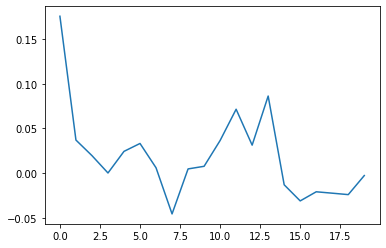

In [8]:
%matplotlib inline
plt.plot(tmp[:, 0])
plt.show()

In [9]:
k = 24
m = 6
r = 6

df['Prediction'] = None
df['Measurement'] = None

alpha = 1.05
W = np.diag(alpha ** np.arange(k) / np.sum(alpha ** np.arange(k)))
# W = np.diag(np.arange(k) / np.sum(np.arange(k)))

THETA = []

for n in np.arange(1440 // int(timeframe/timedelta(minutes=1)) * 4) + 1440*3 // int(timeframe/timedelta(minutes=1)):
    A = np.zeros([k, m+r])
    A[:, m:m+r] = df.iloc[(n-2)-(k-1):(n-2)+1][[f'Feature {i+1}' for i in range(r)]].to_numpy()
    for i in range(m):
        A[:, i] = df.iloc[(n-2)-(k-1)-i:(n-2)-i+1]['Real Return']
    b = df.iloc[(n-1)-(k-1):(n-1)+1]['Real Return'].values
    theta, _, _, _ = np.linalg.lstsq(np.dot(W, A), np.dot(W, b), rcond=-1)
    THETA.append(theta)

    prediction = np.dot(theta, np.concatenate([df.iloc[n-1:n-m-1:-1]['Real Return'].values,
                                               df.iloc[n-1][[f'Feature {i+1}' for i in range(r)]].values]).ravel())
    df.loc[df.index[n], 'Prediction'] = (1 + prediction / (100 * RETURN_SCALE)) * df.iloc[n-1]['Weighted Price Average']
    df.loc[df.index[n], 'Measurement'] = df.iloc[n]['Open']

df

,Open,High,Low,Close,Volume,Value,No. Trades,Taker Buy Volume,Taker Buy Value,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Weighted Price Average,Real Return,Prediction,Measurement
2020-01-01 00:00:00,7195.24,7196.25,7178.20,7191.07,154.874358,1112798.396616,1758,57.539758,413472.913246,37.15254,NaN,1.538932,NaN,NaN,NaN,7185.168746,-13.997107,None,None
2020-01-01 00:10:00,7193.15,7193.53,7177.35,7178.29,80.261439,576609.058442,1270,32.385541,232688.054959,40.350063,-48.176419,1.866626,NaN,NaN,NaN,7184.135565,-1.437935,None,None
2020-01-01 00:20:00,7177.71,7185.56,7175.47,7178.45,96.049725,689540.191655,1372,45.425852,326135.038171,47.294099,19.671073,1.351037,NaN,NaN,NaN,7178.991836,-7.159844,None,None
2020-01-01 00:30:00,7178.19,7185.44,7176.23,7177.53,59.973326,430664.041393,1150,29.54022,212136.847958,49.255597,-37.560127,0.994562,NaN,NaN,NaN,7180.926424,2.694790,None,None
2020-01-01 00:40:00,7177.14,7182.99,7176.34,7182.94,44.872982,322202.599231,818,27.521907,197610.588573,61.332913,-25.178433,-0.739896,NaN,NaN,NaN,7180.325106,-0.837382,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-07 23:10:00,8042.26,8080.54,8040.80,8066.41,458.817809,3699697.185584,4886,245.031574,1975469.708868,53.404983,70.100041,-3.843946,10.480641,41.901578,26.188374,8063.543117,29.024274,8047.747718,8042.26
2020-01-07 23:20:00,8066.72,8082.33,8065.17,8078.61,242.486847,1957859.392795,3268,116.949477,944280.590955,48.229204,-47.149644,0.421437,4.401325,37.697291,23.560706,8074.084912,13.073404,8125.094296,8066.72
2020-01-07 23:30:00,8078.0,8150.57,8078.00,8135.0,787.688054,6389870.063615,7012,465.850505,3778540.045392,59.141497,224.837435,-3.41288,11.558162,19.718729,11.415279,8112.183537,47.186306,8079.294288,8078.0
2020-01-07 23:40:00,8135.22,8207.68,8122.84,8171.74,1503.897763,12291193.941555,12266,877.420526,7172993.879398,58.343097,90.925552,6.493125,18.736315,12.459266,7.42608,8172.891964,74.836112,8148.784292,8135.22


In [10]:
indices = (df['Measurement'] - df['Weighted Price Average']).dropna().index

print(
    (df.loc[indices, 'Measurement'] - df.loc[indices, 'Weighted Price Average']).var(),
    (df.loc[indices, 'Prediction'] - df.loc[indices, 'Weighted Price Average']).var(),
    (df.shift(1).loc[indices, 'Weighted Price Average'] - df.loc[indices, 'Weighted Price Average']).var()
)

df.loc[indices]

123.06694298085853 492.41414405530156 198.6163289608532


,Open,High,Low,Close,Volume,Value,No. Trades,Taker Buy Volume,Taker Buy Value,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Weighted Price Average,Real Return,Prediction,Measurement
2020-01-04 00:00:00,7345.0,7350.00,7320.58,7330.83,418.917101,3074573.290919,3731,237.725142,1744694.439191,56.747538,44.553229,-0.664888,40.188679,35.300566,13.890554,7339.335834,16.422020,7347.756081,7345.0
2020-01-04 00:10:00,7330.83,7331.29,7315.72,7316.78,164.888036,1207308.260648,2024,81.797801,598915.347786,49.608087,-60.639459,-0.237919,77.634961,48.136305,16.521837,7321.988241,-23.636462,7343.780819,7330.83
2020-01-04 00:20:00,7316.58,7323.97,7309.38,7316.39,129.53026,947827.639843,1517,65.816654,481649.50508,50.811798,-21.443506,1.741051,82.742491,48.4926,16.594876,7317.422507,-6.235648,7296.818844,7316.58
2020-01-04 00:30:00,7316.97,7317.00,7289.98,7309.5,271.228827,1980347.532591,2655,132.694839,969073.185792,48.923575,109.394181,4.363111,67.477507,52.996486,17.885235,7301.390322,-21.909606,7314.828266,7316.97
2020-01-04 00:40:00,7309.5,7311.27,7290.80,7300.37,130.422169,952359.125111,1502,70.040453,511433.584821,53.702874,-51.914341,-0.448713,82.689104,60.035647,19.595101,7302.126106,1.007732,7309.46634,7309.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-07 23:10:00,8042.26,8080.54,8040.80,8066.41,458.817809,3699697.185584,4886,245.031574,1975469.708868,53.404983,70.100041,-3.843946,10.480641,41.901578,26.188374,8063.543117,29.024274,8047.747718,8042.26
2020-01-07 23:20:00,8066.72,8082.33,8065.17,8078.61,242.486847,1957859.392795,3268,116.949477,944280.590955,48.229204,-47.149644,0.421437,4.401325,37.697291,23.560706,8074.084912,13.073404,8125.094296,8066.72
2020-01-07 23:30:00,8078.0,8150.57,8078.00,8135.0,787.688054,6389870.063615,7012,465.850505,3778540.045392,59.141497,224.837435,-3.41288,11.558162,19.718729,11.415279,8112.183537,47.186306,8079.294288,8078.0
2020-01-07 23:40:00,8135.22,8207.68,8122.84,8171.74,1503.897763,12291193.941555,12266,877.420526,7172993.879398,58.343097,90.925552,6.493125,18.736315,12.459266,7.42608,8172.891964,74.836112,8148.784292,8135.22


In [11]:
THETA = pd.DataFrame(THETA, index=indices)
THETA

,0,1,2,3,4,5,6,7,8,9,10,11
2020-01-04 00:00:00,-0.195290,-0.502605,-0.138803,-0.216150,-0.142444,-0.462594,-0.165013,-0.025195,0.390945,-0.581752,-1.441999,7.171136
2020-01-04 00:10:00,-0.107907,-0.431176,-0.050940,-0.198375,-0.088290,-0.450651,-0.204294,-0.030352,0.266851,-0.511258,-1.120723,5.962816
2020-01-04 00:20:00,-0.336295,-0.485668,0.023708,-0.104697,-0.094904,-0.340397,-0.281162,-0.053745,1.605535,-0.897759,-0.238821,4.025970
2020-01-04 00:30:00,-0.478269,-0.233409,0.042212,0.011731,-0.059667,-0.306573,-0.331874,-0.080263,3.648335,-0.634670,-0.593759,4.715726
2020-01-04 00:40:00,-0.528229,-0.154983,-0.074154,0.046841,-0.073125,-0.243566,-0.367265,-0.072195,3.070176,-0.778732,-0.401307,4.532547
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-07 23:10:00,-0.532551,-0.602075,-0.704047,0.041458,-0.070358,0.311291,0.902643,0.336757,0.295791,-1.529484,-0.175426,1.202050
2020-01-07 23:20:00,-0.504954,-0.630600,-0.638429,0.139528,-0.028954,0.286508,0.846873,0.352207,0.360239,-1.606989,-0.900919,2.722978
2020-01-07 23:30:00,-0.404024,-0.520199,-0.481915,0.059253,-0.276841,0.224106,0.725412,0.210241,1.405096,-1.223137,-0.562200,1.413390
2020-01-07 23:40:00,-0.309588,-0.544638,-0.416690,0.040742,-0.170082,0.385677,0.677657,0.149927,1.759123,-1.420867,-2.608395,5.238112


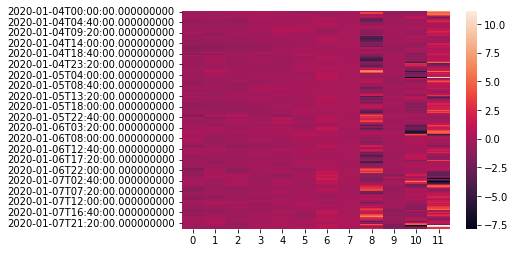

In [12]:
%matplotlib inline

import seaborn as sns
sns.heatmap(THETA)
plt.show()

In [13]:
df['Measurement Residual'] = df['Measurement'] - df['Weighted Price Average']
df['Prediction Residual'] = df['Prediction'] - df['Weighted Price Average']
df['Measurement Residual Weighted Variance'] = df['Measurement Residual'].rolling(12).var()
df['Prediction Residual Weighted Variance'] = df['Prediction Residual'].rolling(6).var()
df['Kalman Gain'] = df['Prediction Residual Weighted Variance'] / \
                    (df['Measurement Residual Weighted Variance'] + df['Prediction Residual Weighted Variance'])
df['Estimate'] = df['Kalman Gain'] * df['Measurement'] + (1 - df['Kalman Gain']) * df['Prediction']
df['Estimate Uncertainty'] = df['Kalman Gain'] ** 2 * df['Measurement Residual Weighted Variance'] + \
                             (1 - df['Kalman Gain']) ** 2 * df['Prediction Residual Weighted Variance']
df.loc[indices]

,Open,High,Low,Close,Volume,Value,No. Trades,Taker Buy Volume,Taker Buy Value,Feature 1,...,Real Return,Prediction,Measurement,Measurement Residual,Prediction Residual,Measurement Residual Weighted Variance,Prediction Residual Weighted Variance,Kalman Gain,Estimate,Estimate Uncertainty
2020-01-04 00:00:00,7345.0,7350.00,7320.58,7330.83,418.917101,3074573.290919,3731,237.725142,1744694.439191,56.747538,...,16.422020,7347.756081,7345.0,5.664166,8.420247,NaN,NaN,NaN,NaN,NaN
2020-01-04 00:10:00,7330.83,7331.29,7315.72,7316.78,164.888036,1207308.260648,2024,81.797801,598915.347786,49.608087,...,-23.636462,7343.780819,7330.83,8.841759,21.792578,NaN,NaN,NaN,NaN,NaN
2020-01-04 00:20:00,7316.58,7323.97,7309.38,7316.39,129.53026,947827.639843,1517,65.816654,481649.50508,50.811798,...,-6.235648,7296.818844,7316.58,-0.842507,-20.603663,NaN,NaN,NaN,NaN,NaN
2020-01-04 00:30:00,7316.97,7317.00,7289.98,7309.5,271.228827,1980347.532591,2655,132.694839,969073.185792,48.923575,...,-21.909606,7314.828266,7316.97,15.579678,13.437943,NaN,NaN,NaN,NaN,NaN
2020-01-04 00:40:00,7309.5,7311.27,7290.80,7300.37,130.422169,952359.125111,1502,70.040453,511433.584821,53.702874,...,1.007732,7309.46634,7309.5,7.373894,7.340234,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-07 23:10:00,8042.26,8080.54,8040.80,8066.41,458.817809,3699697.185584,4886,245.031574,1975469.708868,53.404983,...,29.024274,8047.747718,8042.26,-21.283117,-15.795399,447.789899,4167.936517,0.902986,8042.792385,404.348027
2020-01-07 23:20:00,8066.72,8082.33,8065.17,8078.61,242.486847,1957859.392795,3268,116.949477,944280.590955,48.229204,...,13.073404,8125.094296,8066.72,-7.364912,51.009384,415.953939,2760.304970,0.869043,8074.364534,361.481780
2020-01-07 23:30:00,8078.0,8150.57,8078.00,8135.0,787.688054,6389870.063615,7012,465.850505,3778540.045392,59.141497,...,47.186306,8079.294288,8078.0,-34.183537,-32.889248,510.200855,2431.515391,0.826564,8078.224477,421.713424
2020-01-07 23:40:00,8135.22,8207.68,8122.84,8171.74,1503.897763,12291193.941555,12266,877.420526,7172993.879398,58.343097,...,74.836112,8148.784292,8135.22,-37.671964,-24.107672,593.036108,1479.582776,0.713871,8139.101136,423.351354


In [14]:
%matplotlib notebook

plt.xticks(rotation=90)
plt.plot(
    indices,
    df.loc[indices, 'Weighted Price Average'],
    color='black'
)

# plot measurement errors
plt.vlines(
    x=indices,
    ymin=df.loc[indices, 'Weighted Price Average'],
    ymax=df.loc[indices, 'Measurement'],
    color='red'
)
plt.scatter(
    indices,
    df.loc[indices, 'Measurement'],
    color='red'
)

# plot model approximation errors
plt.vlines(
    x=indices,
    ymin=df.loc[indices, 'Weighted Price Average'],
    ymax=df.loc[indices, 'Prediction'],
    color='blue'
)
plt.scatter(
    indices,
    df.loc[indices, 'Prediction'],
    color='blue'
)

# plot model approximation errors
plt.vlines(
    x=indices,
    ymin=df.loc[indices, 'Weighted Price Average'],
    ymax=df.loc[indices, 'Estimate'],
    color='green'
)
plt.scatter(
    indices,
    df.loc[indices, 'Estimate'],
    color='green',
    marker='x'
)
plt.show()

<IPython.core.display.Javascript object>

/home/m.ghodrati@rasad.local/.local/lib/python3.10/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/m.ghodrati@rasad.local/.local/lib/python3.10/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


In [19]:
print(
    "Measurement:\t",
    (df.loc[indices, 'Measurement'] - df.loc[indices, 'Weighted Price Average']).std(),
    "\n Prediction:\t",
    (df.loc[indices, 'Prediction'] - df.loc[indices, 'Weighted Price Average']).std(),
    "\n   Estimate:\t",
    (df.loc[indices, 'Estimate'] - df.loc[indices, 'Weighted Price Average']).std(),
    "   R_square:",
    1 - (df.loc[indices, 'Estimate'] - df.loc[indices, 'Weighted Price Average']).var() /
        (df.shift(1).loc[indices, 'Weighted Price Average'] - df.loc[indices, 'Weighted Price Average']).var(),
    "\n   Base std:\t",
    (df.shift(1).loc[indices, 'Weighted Price Average'] - df.loc[indices, 'Weighted Price Average']).std()
)

Measurement:	 13.334839260567822 
 Prediction:	 18.817186165400003 
   Estimate:	 13.376925728125677    R_square: 0.2933343577062122 
   Base std:	 15.912899774634583


In [16]:
# from scipy.stats import pearsonr
# result = []
# data = df.dropna().copy()
# data = data[(data['Feature 2'] >= 3) & (data['No. Trades'] > 100)]
# for i in range(period):
#     for j in range(4):
#         result.append(pearsonr(data[f'Return {i+1} min'], data[f'Feature {j+1}']))
# result = np.array(result)
# result = result.reshape(-1, 8)
# for j in range(4):
#     plt.plot(result[:, 2*j], label=f'Feature {j+1}')
# plt.legend()
# plt.title(f'n = {len(data)}')
# plt.show()

In [17]:
# t_train_start = datetime(2018, 1, 1, 1)
# t_train_duration = timedelta(hours=6)
# x_train = x.loc[t_train_start:t_train_start+t_train_duration-timedelta(minutes=1)]
# A =

In [18]:
indices = df.dropna().index
df['Volume Change'] = df.Volume.pct_change() * 100
indices = df.loc[indices].loc[(df.loc[indices, 'Volume Change'] >= 0) &
                              (np.sqrt(df.loc[indices, 'Estimate Uncertainty']) < 20)].index

print(
    "Measurement:\t",
    (df.loc[indices, 'Measurement'] - df.loc[indices, 'Weighted Price Average']).std(),
    "\n Prediction:\t",
    (df.loc[indices, 'Prediction'] - df.loc[indices, 'Weighted Price Average']).std(),
    "\n   Estimate:\t",
    (df.loc[indices, 'Estimate'] - df.loc[indices, 'Weighted Price Average']).std(),
    "   R_square:",
    1 - np.sqrt((df.loc[indices, 'Estimate'] - df.loc[indices, 'Weighted Price Average']).var() /
        (df.shift(1).loc[indices, 'Weighted Price Average'] - df.loc[indices, 'Weighted Price Average']).var()),
    "\n   Base std:\t",
    (df.shift(1).loc[indices, 'Weighted Price Average'] - df.loc[indices, 'Weighted Price Average']).std()
)

Measurement:	 13.334839260567822 
 Prediction:	 18.817186165400003 
   Estimate:	 13.376925728125677    R_square: 0.15936592842439 
   Base std:	 15.912899774634583
